<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/Testonsensor255-patient1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount("/gdrive")


Mounted at /gdrive


In [2]:
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import os
from IPython.core.completer import time
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np

In [16]:

import os
from IPython.core.completer import time
from skimage.transform import resize
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pickle

class DataLoader:
    def __init__(
        self,
        *,
        data_path,
        timesteps: int = 3,
        batch_size: int = 255,
        squeeze=False,
        augmentation=False,
        shuffle=True,
        sort_method="natsort"  # oppure "number"
    ):
        self.shuffle = shuffle
        self.do_augmentation = augmentation
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.squeeze = squeeze
        self.data_path = data_path
        train_img_file_names = [
            os.path.join(data_path, fn)
            for fn in os.listdir(
                data_path
            )  # os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]

        def sort_by_number(file_names: list):
            return sorted(file_names, key=lambda x: int(x.split("/")[-1].split(".")[0]))

        train_img_file_names = (
            natsorted(train_img_file_names)
            if sort_method == "natsort"
            else sort_by_number(train_img_file_names)
        )
        self.filenames = train_img_file_names
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        if not os.path.exists("imgs.pickle"):
            self.imgs = (
                np.array(
                    [
                        resize(img_to_array(load_img(fn, color_mode="grayscale")),(256, 256))
                        for fn in train_img_file_names
                    ]
                )
                / 255
            )
            with open("imgs.pickle", "wb") as f:
                pickle.dump(self.imgs, f)
        else:
            print("Loading imgs from pickle")
            with open("imgs.pickle", "rb") as f:
                self.imgs = pickle.load(f)
        if not os.path.exists("masks.pickle"):
            self.masks = (
                np.array(
                    [
                        resize(img_to_array(load_img(fn, color_mode="grayscale")), (256, 256))
                        for fn in train_mask_file_names
                    ]
                )
                / 255
                > 0.5
            ).astype(float)
            with open("masks.pickle", "wb") as f:
                pickle.dump(self.masks, f)
        else:
            print("Loading masks from pickle file")
            with open("masks.pickle", "rb") as f:
                self.masks = pickle.load(f)

        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
            ]
        )
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        if self.shuffle:
            for _ in range(self.batch_size):
                index = np.random.randint(0, len(self.imgs) - self.timesteps)
                xs.append(self.imgs[index : index + self.timesteps])
                ys.append(self.masks[index + self.timesteps])
        else:
            # i = np.random.randint(0, len(self.imgs) - self.timesteps - self.batch_size)
            xs = [
                self.imgs[i * self.timesteps : (i + 1) * self.timesteps]
                for i in range(self.index, self.batch_size // self.timesteps)
            ]
            ys = [
                self.masks[(i + 1) * self.timesteps]
                for i in range(self.index, self.batch_size // self.timesteps)
            ]
            self.index += self.batch_size // self.timesteps
            if self.index >= len(self.imgs) - self.timesteps - self.batch_size:
                self.index = 0
                raise StopIteration
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = tf.concat((x, y), axis=-1)
        if self.do_augmentation:
            xy = self.augmentation(xy)

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        return x, y

In [17]:

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TEST/TEST-TOTALE/HCM-001/test_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TEST/TEST-TOTALE/HCM-001/test_masks/masks'))

In [18]:
num_train_imgs

255

In [19]:
num_val_images

255

In [20]:
val_loader = DataLoader(
        data_path=os.path.join(
                   "/gdrive/MyDrive/TEST/TEST-TOTALE/HCM-001",
        "test_images", "images"

        ),
        batch_size=255,
        squeeze=False,
        augmentation=False,

)

Loading imgs from pickle
Loading masks from pickle file


In [21]:
a, b = val_loader.__next__()


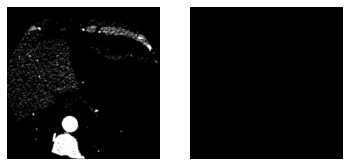

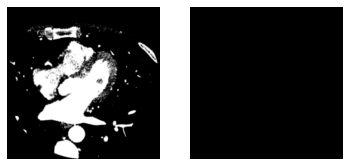

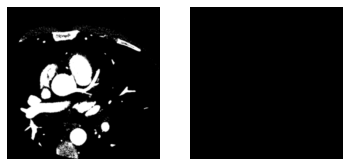

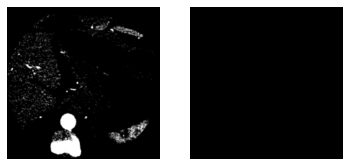

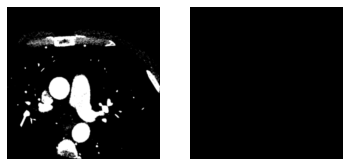

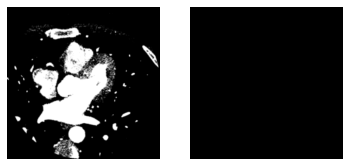

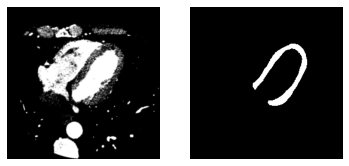

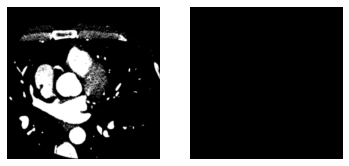

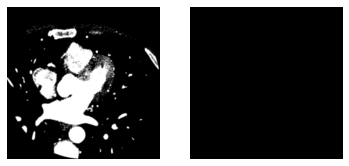

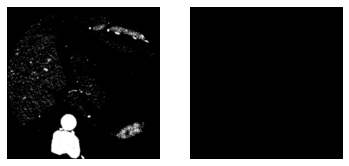

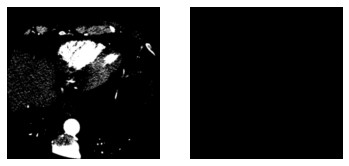

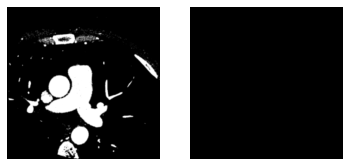

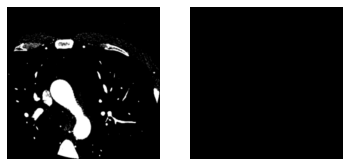

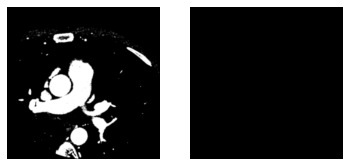

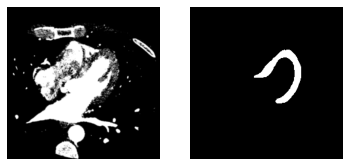

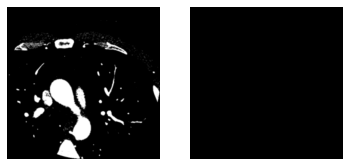

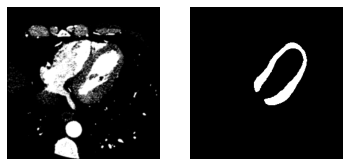

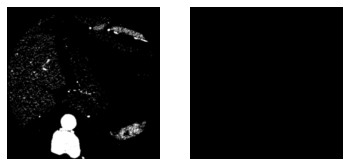

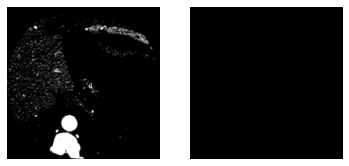

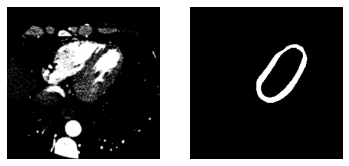

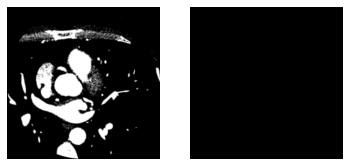

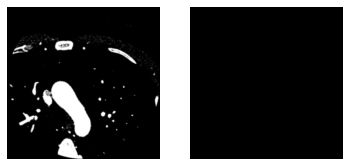

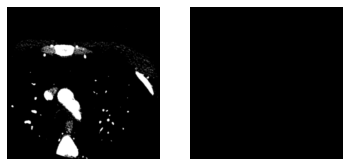

In [22]:
for i in range(0,223,10):
    image = a[i, 0, :, :, 0]
    # mask = np.argmax(y[i], axis=2)
    mask = b[i, 0, :, :, 0]
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap="gray")
    plt.axis("off")
    plt.show()


In [23]:
# Load previously saved model
from keras.models import load_model

model = load_model(
    "/gdrive/MyDrive/TEST/Sensor30.unet-1111-5e-5-noaugonvalidation-relu-recurrentdropout0.2-3blocks-batch12-convlstm.savethebest (1).h5",
    compile=False,
)

1/1 [==============================] - 2s 2s/step


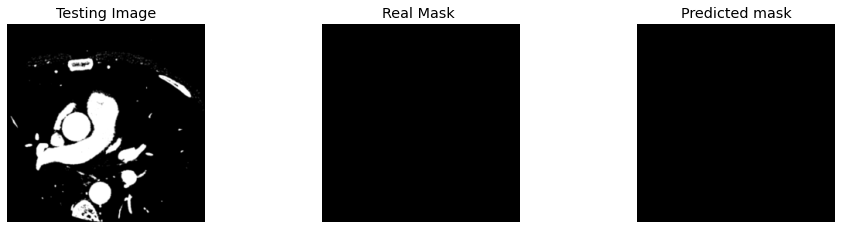

In [24]:


import random

test_img_number = random.randint(0, a.shape[0] - 1)
test_img = a[test_img_number]
ground_truth = b[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0, 0, :, :, 0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis("off")
plt.title("Testing Image")
plt.imshow(test_img[0, :, :, 0], cmap="gray")


plt.subplot(232)
plt.title("Real Mask ")
plt.axis("off")
plt.imshow(ground_truth[0, :, :, 0], cmap="gray")
plt.subplot(233)
plt.axis("off")

plt.title("Predicted mask")
plt.imshow(prediction, cmap="gray")

plt.show()

In [25]:
# IoU for a single image
from tensorflow.keras.metrics import MeanIoU

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(ground_truth[0, :, :, 0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 1.0


In [26]:

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth = b[img]
    temp_img_input = np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0, 0, :, :, 0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[0, :, :, 0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 1s 667ms/step
1.0
1/1 [==============================] - 1s 708ms/step
1.0
1/1 [==============================] - 1s 702ms/step
1.0
1/1 [==============================] - 1s 687ms/step
0.47677612
1/1 [==============================] - 1s 678ms/step
1.0
1/1 [==============================] - 1s 688ms/step
1.0
1/1 [==============================] - 1s 671ms/step
1.0
1/1 [==============================] - 1s 673ms/step
1.0
1/1 [==============================] - 1s 679ms/step
0.6023437
1/1 [==============================] - 1s 678ms/step
0.4771576
1/1 [==============================] - 1s 669ms/step
1.0
1/1 [==============================] - 1s 667ms/step
1.0
1/1 [==============================] - 1s 698ms/step
0.87396884
1/1 [==============================] - 1s 682ms/step
1.0
1/1 [==============================] - 1s 683ms/step
0.83349884
1/1 [==============================] - 1s 719ms/step
1.0
1/1 [==============================] - 1s 691ms/step
1.